In [124]:
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.model_selection import cross_val_score    # 交叉驗證
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score  
import matplotlib.pyplot as plt
import seaborn as sns

## 匯入資料及確認各欄位資料型態

In [128]:
df = pd.read_csv('corr_all_2.csv')

df = df.rename(columns={'時間':'time'})
df['time'] = df['time'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
df = df.set_index('time')
df

,Snow Peak,Fjallraven,Hilleberg,MAMMUT,100mountain,mont-bell,Zamberlan,MysteryRanch,始祖鳥 Arcteryx,Komperdell,...,south_easy,south_normal,south_hard,central_easy,central_normal,central_hard,east_easy,east_normal,east_hard,total
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,40185,48893,0.0,88365,19534,28634,14443.0,34755.0,23125.0,13620.0,...,1886.0,600.0,14.0,8910.0,627.0,0.0,2577.0,1918.0,1249.0,32882
2020-01-02,47640,19017,0.0,15410,6987,13619,0.0,0.0,35180.0,6735.0,...,581.0,0.0,0.0,616.0,39.0,0.0,401.0,1142.0,136.0,10909
2020-01-03,32784,27280,11898.0,16520,8359,7100,5100.0,27577.0,30420.0,9502.0,...,932.0,0.0,0.0,2544.0,127.0,0.0,671.0,2100.0,564.0,15479
2020-01-04,18878,54679,0.0,47980,9616,31620,28300.0,2970.0,25530.0,455.0,...,3704.0,0.0,0.0,11258.0,1425.0,34.0,5162.0,1590.0,588.0,48455
2020-01-05,17874,37662,55794.0,22161,6136,13813,8550.0,10990.0,0.0,15509.0,...,2597.0,0.0,0.0,2832.0,1295.0,182.0,101.0,803.0,407.0,30372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,135099,82404,0.0,149947,53395,80540,41150.0,44507.0,76833.0,13765.0,...,3387.0,797.0,8.0,3252.0,883.0,39.0,1013.0,1401.0,948.0,20918
2020-12-28,53582,76679,0.0,19907,27185,23860,37980.0,12960.0,29260.0,14124.0,...,89.0,669.0,85.0,1214.0,721.0,15.0,364.0,201.0,294.0,6748
2020-12-29,82110,59021,35200.0,85262,63977,73425,73130.0,1530.0,92220.0,12690.0,...,0.0,0.0,0.0,699.0,406.0,0.0,2085.0,365.0,106.0,5811


## 資料正規化，使用Minmax

#### 考量原因:銷售金額總金額總數遠大於登山人次，且希望使走勢圖更為明顯

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler()

In [131]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['Snow Peak', 'Fjallraven', 'Hilleberg', 'MAMMUT', '100mountain'\
            ,'mont-bell','Zamberlan','MysteryRanch','始祖鳥 Arcteryx'\
            ,'Komperdell','north_easy','north_normal','north_hard',\
            'south_easy','south_normal','south_hard','central_easy',\
            'central_normal','central_hard','east_easy','east_normal',\
            'east_hard','total']
df_normalized=df
df_normalized[num_vars] = scaler.fit_transform(df_normalized[num_vars])
df_normalized.head()

,Snow Peak,Fjallraven,Hilleberg,MAMMUT,100mountain,mont-bell,Zamberlan,MysteryRanch,始祖鳥 Arcteryx,Komperdell,...,south_easy,south_normal,south_hard,central_easy,central_normal,central_hard,east_easy,east_normal,east_hard,total
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.090160,0.233255,0.027569,0.510253,0.056459,0.246353,0.157323,0.337573,0.269102,0.120214,...,0.128693,0.137615,0.031532,0.748488,0.067967,0.000000,0.151758,0.165587,0.176937,0.366973
2020-01-02,0.102714,0.083560,0.027569,0.116973,0.050290,0.110231,0.044742,0.048634,0.348936,0.061762,...,0.039645,0.000000,0.000000,0.051747,0.004228,0.000000,0.023615,0.098593,0.019266,0.113571
2020-01-03,0.077697,0.124962,0.054022,0.122957,0.050965,0.051131,0.084496,0.277898,0.317413,0.085253,...,0.063596,0.000000,0.000000,0.213710,0.013767,0.000000,0.039515,0.181300,0.079898,0.166275
2020-01-04,0.054279,0.262246,0.027569,0.292549,0.051583,0.273424,0.265336,0.073326,0.285029,0.008447,...,0.252747,0.000000,0.000000,0.945733,0.154472,0.022442,0.303987,0.137270,0.083298,0.546568
2020-01-05,0.052589,0.176982,0.151616,0.153366,0.049872,0.111989,0.111388,0.140001,0.115959,0.136251,...,0.177209,0.000000,0.000000,0.237903,0.140379,0.120132,0.005948,0.069326,0.057657,0.338027


### 開始跑線性回歸

### 所有特徵值的相關係數

In [132]:
corr = df.corr()
corr

,Snow Peak,Fjallraven,Hilleberg,MAMMUT,100mountain,mont-bell,Zamberlan,MysteryRanch,始祖鳥 Arcteryx,Komperdell,...,south_easy,south_normal,south_hard,central_easy,central_normal,central_hard,east_easy,east_normal,east_hard,total
Snow Peak,1.000000,0.275178,0.115725,0.261048,-0.013616,0.231395,0.128456,0.113861,0.188396,0.179841,...,0.111972,0.141820,0.012634,0.217161,0.225932,0.131106,0.108692,0.261390,0.235448,0.256851
Fjallraven,0.275178,1.000000,0.228953,0.375726,-0.026225,0.419874,0.295991,0.273340,0.351384,0.272945,...,0.372795,0.339089,0.112840,0.363251,0.383717,0.214878,0.271604,0.377536,0.332959,0.451129
Hilleberg,0.115725,0.228953,1.000000,0.147632,-0.042610,0.130754,0.172757,0.188526,0.089082,0.119532,...,0.180227,0.178745,0.126513,0.120503,0.101174,-0.028443,0.120729,0.039126,0.103827,0.138267
MAMMUT,0.261048,0.375726,0.147632,1.000000,0.071700,0.480901,0.253498,0.166475,0.397457,0.275988,...,0.283855,0.256064,0.137626,0.263150,0.360701,0.186154,0.202642,0.280371,0.272138,0.363446
100mountain,-0.013616,-0.026225,-0.042610,0.071700,1.000000,0.051441,-0.037805,-0.048972,0.042792,-0.031448,...,-0.054746,0.011328,-0.008480,-0.036260,0.000525,-0.026955,-0.024973,0.016543,-0.003895,-0.030787
mont-bell,0.231395,0.419874,0.130754,0.480901,0.051441,1.000000,0.231190,0.089228,0.412225,0.228917,...,0.223111,0.227708,0.234513,0.173035,0.268860,0.204850,0.135141,0.232025,0.227913,0.282927
Zamberlan,0.128456,0.295991,0.172757,0.253498,-0.037805,0.231190,1.000000,0.352836,0.242501,0.292907,...,0.291473,0.290211,0.146484,0.315966,0.326138,0.116638,0.235796,0.301229,0.338529,0.392923
MysteryRanch,0.113861,0.273340,0.188526,0.166475,-0.048972,0.089228,0.352836,1.000000,0.092479,0.212682,...,0.225847,0.277626,-0.008183,0.230685,0.241586,0.136412,0.179529,0.177725,0.271129,0.345393
始祖鳥 Arcteryx,0.188396,0.351384,0.089082,0.397457,0.042792,0.412225,0.242501,0.092479,1.000000,0.205251,...,0.170160,0.218753,0.149953,0.144590,0.202226,0.182059,0.075650,0.196972,0.154627,0.207558
Komperdell,0.179841,0.272945,0.119532,0.275988,-0.031448,0.228917,0.292907,0.212682,0.205251,1.000000,...,0.260289,0.304213,0.067275,0.265374,0.399737,0.255667,0.168162,0.388375,0.414752,0.434149


## 篩選出相關係數較高者為分析目標

In [151]:
corr = df.corr()['east_hard'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 17 strongly correlated values with SalePrice:
east_hard         1.000000
east_normal       0.833467
total             0.780254
north_normal      0.752098
central_normal    0.749371
north_hard        0.636664
north_easy        0.590220
south_normal      0.573816
central_easy      0.560841
central_hard      0.484533
south_easy        0.447527
Komperdell        0.414752
east_easy         0.389575
Zamberlan         0.338529
Fjallraven        0.332959
MAMMUT            0.272138
MysteryRanch      0.271129
Name: east_hard, dtype: float64


### 熱圖

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31062 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40165 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22987 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31062 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40165 missing from curre

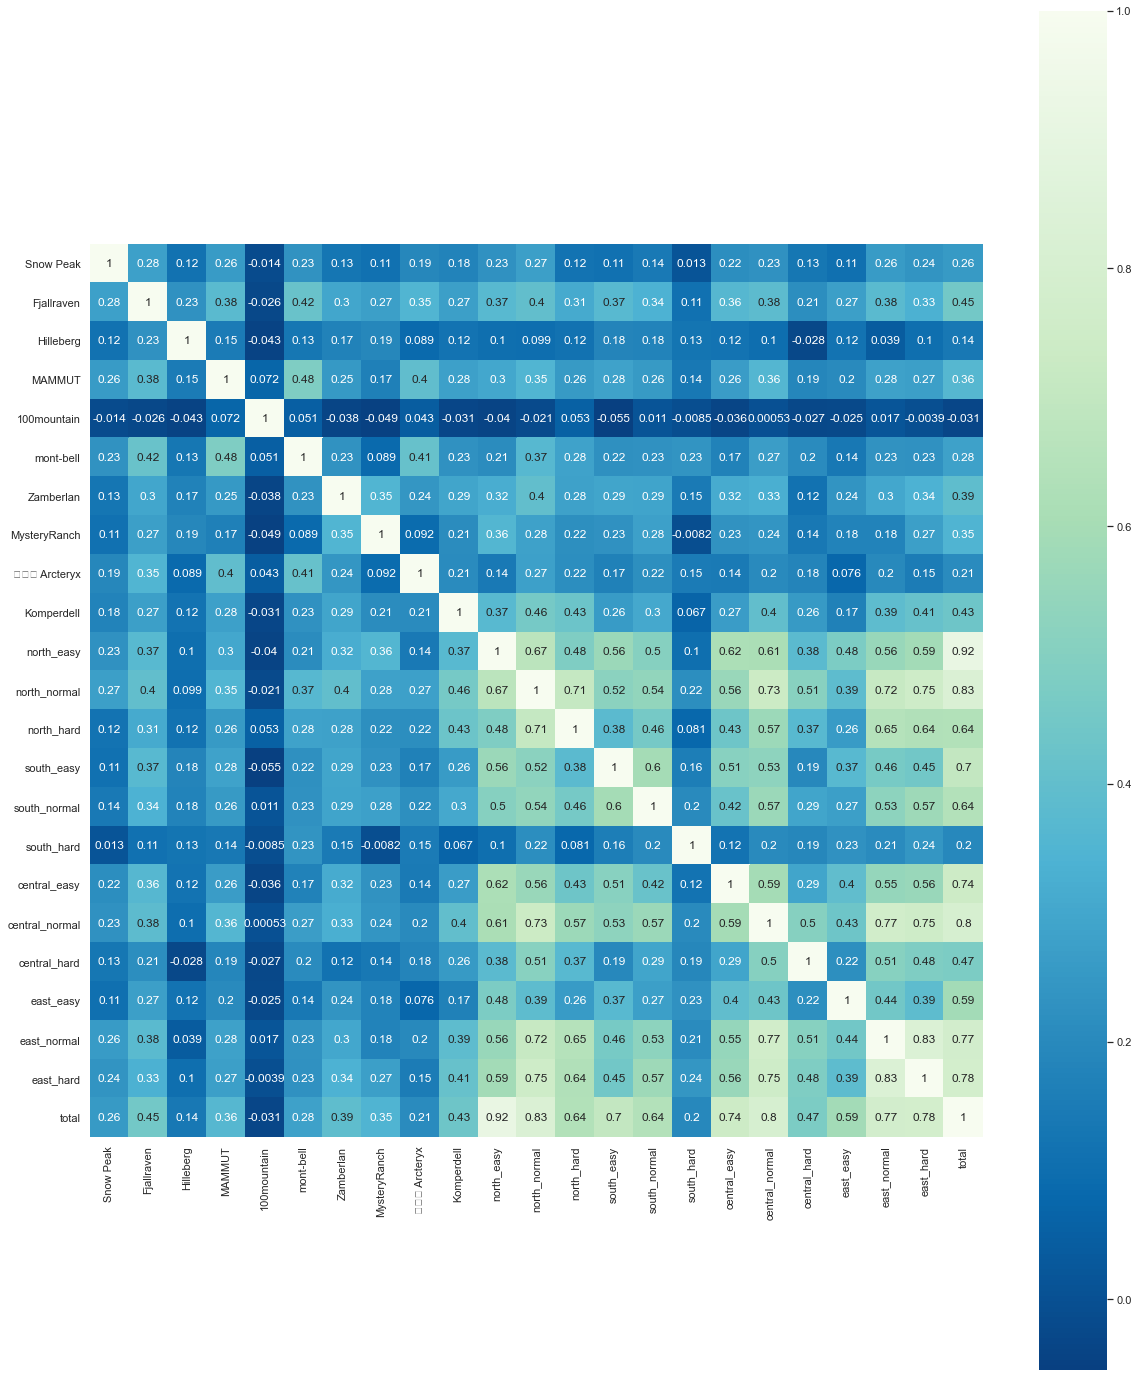

In [133]:
plt.figure(figsize = (20, 25)) #調整大小
sns.heatmap(corr, cmap='GnBu_r', square=True, annot=True)
plt.savefig('xx.png')

### 以不同的特徵值與各欄位比較結果，抓取相關性大於0.25

In [141]:
corr = df.corr()['north_hard'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 17 strongly correlated values with SalePrice:
north_hard        1.000000
north_normal      0.708803
east_normal       0.653389
total             0.641260
east_hard         0.636664
central_normal    0.570540
north_easy        0.482194
south_normal      0.459264
central_easy      0.432095
Komperdell        0.428308
south_easy        0.378882
central_hard      0.371952
Fjallraven        0.307987
mont-bell         0.284945
Zamberlan         0.279661
east_easy         0.261724
MAMMUT            0.258230
Name: north_hard, dtype: float64


In [139]:
corr = df.corr()['Snow Peak'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 6 strongly correlated values with SalePrice:
Snow Peak       1.000000
Fjallraven      0.275178
north_normal    0.271198
east_normal     0.261390
MAMMUT          0.261048
total           0.256851
Name: Snow Peak, dtype: float64


In [95]:
corr = df.corr()['Fjallraven'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 15 strongly correlated values with SalePrice:
Fjallraven        1.000000
mont-bell         0.419874
MAMMUT            0.375726
始祖鳥 Arcteryx      0.351384
total             0.326205
south_easy        0.315247
Zamberlan         0.295991
north_easy        0.288085
north_normal      0.283649
central_normal    0.281963
Snow Peak         0.275178
MysteryRanch      0.273340
Komperdell        0.272945
south_normal      0.266031
east_normal       0.254562
Name: Fjallraven, dtype: float64


In [96]:
corr = df.corr()['MAMMUT'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 11 strongly correlated values with SalePrice:
MAMMUT            1.000000
mont-bell         0.480901
始祖鳥 Arcteryx      0.397457
Fjallraven        0.375726
central_normal    0.305813
north_normal      0.298404
total             0.281467
Komperdell        0.275988
south_easy        0.266700
Snow Peak         0.261048
Zamberlan         0.253498
Name: MAMMUT, dtype: float64


In [97]:
corr = df.corr()['mont-bell'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 4 strongly correlated values with SalePrice:
mont-bell       1.000000
MAMMUT          0.480901
Fjallraven      0.419874
始祖鳥 Arcteryx    0.412225
Name: mont-bell, dtype: float64


In [98]:
corr = df.corr()['Zamberlan'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 12 strongly correlated values with SalePrice:
Zamberlan         1.000000
MysteryRanch      0.352836
north_normal      0.326215
total             0.324513
Fjallraven        0.295991
Komperdell        0.292907
north_easy        0.284829
central_normal    0.281119
east_hard         0.269029
south_easy        0.258627
MAMMUT            0.253498
central_easy      0.251469
Name: Zamberlan, dtype: float64


In [99]:
corr = df.corr()['MysteryRanch'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 9 strongly correlated values with SalePrice:
MysteryRanch      1.000000
north_easy        0.359598
Zamberlan         0.352836
total             0.352685
east_hard         0.305228
north_normal      0.294322
south_normal      0.279812
Fjallraven        0.273340
central_normal    0.254010
Name: MysteryRanch, dtype: float64


In [100]:
corr = df.corr()['始祖鳥 Arcteryx'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 4 strongly correlated values with SalePrice:
始祖鳥 Arcteryx    1.000000
mont-bell       0.412225
MAMMUT          0.397457
Fjallraven      0.351384
Name: 始祖鳥 Arcteryx, dtype: float64


In [101]:
corr = df.corr()['Komperdell'][0:] # -1 because the latest row is SalePrice
golden_features_list = corr[abs(corr) > 0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 11 strongly correlated values with SalePrice:
Komperdell        1.000000
north_normal      0.374091
north_hard        0.349673
total             0.321716
central_normal    0.320169
east_hard         0.315548
north_easy        0.297971
Zamberlan         0.292907
MAMMUT            0.275988
Fjallraven        0.272945
east_normal       0.261712
Name: Komperdell, dtype: float64


### 錯誤測試，發現資料跑完上面資料‧會剩單一欄位。

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31062 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40165 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 22987 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31062 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40165 missing from curre

<AxesSubplot:>

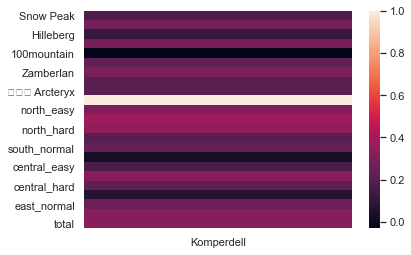

In [119]:
sns.heatmap(corr.to_frame())

### 回歸分析圖

<AxesSubplot:xlabel='east_normal', ylabel='Komperdell'>

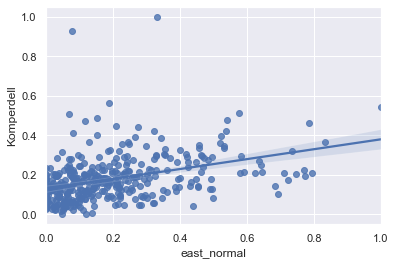

In [175]:
sns.set_theme(color_codes=True)
sns.regplot(x="east_normal", y="Komperdell", data=df_normalized)

<AxesSubplot:xlabel='east_hard', ylabel='Zamberlan'>

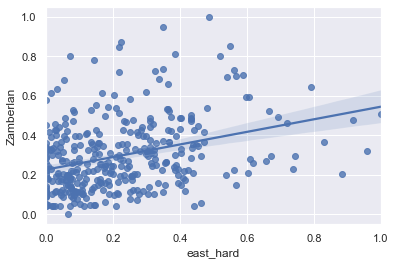

In [169]:
sns.set_theme(color_codes=True)
sns.regplot(x="east_hard", y="Zamberlan", data=df)

<AxesSubplot:xlabel='east_hard', ylabel='Fjallraven'>

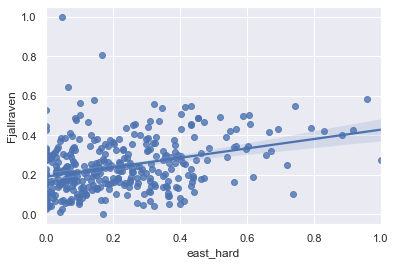

In [137]:
sns.set_theme(color_codes=True)
sns.regplot(x="east_hard", y="Fjallraven", data=df_normalized)

<AxesSubplot:xlabel='north_normal', ylabel='Snow Peak'>

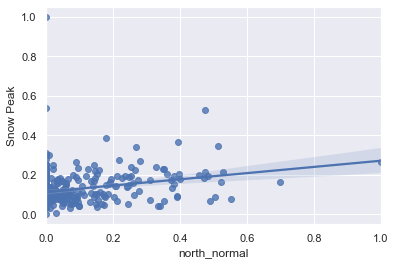

In [82]:
sns.set_theme(color_codes=True)
sns.regplot(x="north_normal", y="Snow Peak", data=df_normalized)


<AxesSubplot:xlabel='Fjallraven', ylabel='mont-bell'>

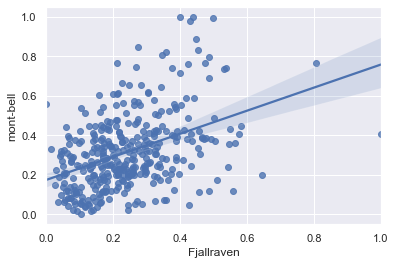

In [86]:
sns.set_theme(color_codes=True)
sns.regplot(x="Fjallraven", y="mont-bell", data=df)